# Method 6 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

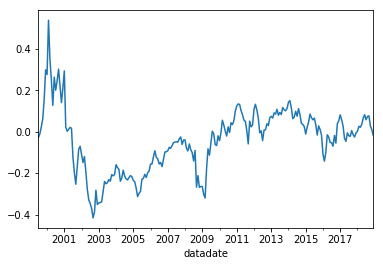

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.298652
2000-12-31   -0.068854
2001-12-31   -0.231170
2002-12-31   -0.302206
2003-12-31    0.222905
2004-12-31   -0.013069
2005-12-31    0.034593
2006-12-31    0.114930
2007-12-31    0.062596
2008-12-31   -0.233542
2009-12-31    0.332511
2010-12-31    0.120970
2011-12-31   -0.060364
2012-12-31    0.033053
2013-12-31    0.042420
2014-12-31   -0.078659
2015-12-31   -0.040322
2016-12-31    0.070629
2017-12-31   -0.055841
2018-12-31   -0.011517
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     69.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-38
Time:                        13:53:49   Log-Likelihood:                 453.00
No. Observations:                 234   AIC:                            -896.0
Df Residuals:                     229   BIC:                            -878.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.522      0.602      -0.003       0.006
mktrf          0.3584      0.066      5.444      0.000       0.229       0.488
me             0.3531      0.077      4.612      0.000       0.202       0.504
ia            -0.2747      0.116     -2.361      0.019      -0.504      -0.045
roe           -0.6174      0.100     -6.198      0.000      -0.814      -0.421
==============================================================================
Omnibus:                       46.789   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.088
Skew:                           0.496   Prob(JB):                     1.42e-74
Kurtosis:                       8.822   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     36.29
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-23
Time:                        13:53:49   Log-Likelihood:                 453.00
No. Observations:                 234   AIC:                            -896.0
Df Residuals:                     229   BIC:                            -878.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.667      0.505      -0.002       0.005
mktrf          0.3584      0.089      4.027      0.000       0.184       0.533
me             0.3531      0.133      2.656      0.008       0.093       0.614
ia            -0.2747      0.176     -1.560      0.119      -0.620       0.070
roe           -0.6174      0.155     -3.973      0.000      -0.922      -0.313
==============================================================================
Omnibus:                       46.789   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.088
Skew:                           0.496   Prob(JB):                     1.42e-74
Kurtosis:                       8.822   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     63.22
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.15e-36
Time:                        13:53:49   Log-Likelihood:                 453.00
No. Observations:                 234   AIC:                            -896.0
Df Residuals:                     229   BIC:                            -878.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.657      0.511      -0.002       0.005
mktrf          0.3584      0.088      4.050      0.000       0.185       0.532
me             0.3531      0.147      2.407      0.016       0.066       0.641
ia            -0.2747      0.150     -1.831      0.067      -0.569       0.019
roe           -0.6174      0.161     -3.842      0.000      -0.932      -0.302
==============================================================================
Omnibus:                       46.789   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.088
Skew:                           0.496   Prob(JB):                     1.42e-74
Kurtosis:                       8.822   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     61.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-40
Time:                        13:53:49   Log-Likelihood:                 460.45
No. Observations:                 234   AIC:                            -908.9
Df Residuals:                     228   BIC:                            -888.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.658      0.511      -0.003       0.006
mktrf          0.4015      0.064      6.270      0.000       0.275       0.528
smb            0.2811      0.084      3.327      0.001       0.115       0.448
hml           -0.1374      0.100     -1.380      0.169      -0.334       0.059
rmw           -0.7199      0.113     -6.392      0.000      -0.942      -0.498
cma            0.0872      0.143      0.609      0.543      -0.195       0.369
==============================================================================
Omnibus:                       62.008   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.329
Skew:                           0.921   Prob(JB):                     1.24e-69
Kurtosis:                       8.399   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     79.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.77e-48
Time:                        13:53:49   Log-Likelihood:                 460.45
No. Observations:                 234   AIC:                            -908.9
Df Residuals:                     228   BIC:                            -888.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.076      0.282      -0.001       0.004
mktrf          0.4015      0.054      7.473      0.000       0.296       0.507
smb            0.2811      0.080      3.511      0.000       0.124       0.438
hml           -0.1374      0.169     -0.815      0.415      -0.468       0.193
rmw           -0.7199      0.135     -5.352      0.000      -0.984      -0.456
cma            0.0872      0.193      0.452      0.651      -0.291       0.465
==============================================================================
Omnibus:                       62.008   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.329
Skew:                           0.921   Prob(JB):                     1.24e-69
Kurtosis:                       8.399   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     131.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.06e-65
Time:                        13:53:49   Log-Likelihood:                 460.45
No. Observations:                 234   AIC:                            -908.9
Df Residuals:                     228   BIC:                            -888.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.070      0.285      -0.001       0.004
mktrf          0.4015      0.048      8.390      0.000       0.308       0.495
smb            0.2811      0.086      3.255      0.001       0.112       0.450
hml           -0.1374      0.148     -0.926      0.354      -0.428       0.153
rmw           -0.7199      0.136     -5.275      0.000      -0.987      -0.452
cma            0.0872      0.152      0.575      0.566      -0.210       0.385
==============================================================================
Omnibus:                       62.008   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.329
Skew:                           0.921   Prob(JB):                     1.24e-69
Kurtosis:                       8.399   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     65.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.53e-37
Time:                        13:53:49   Log-Likelihood:                 449.39
No. Observations:                 234   AIC:                            -888.8
Df Residuals:                     229   BIC:                            -871.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.431      0.667      -0.006       0.004
mktrf          0.4882      0.062      7.932      0.000       0.367       0.609
smb            0.6019      0.077      7.834      0.000       0.451       0.753
hml           -0.2804      0.076     -3.675      0.000      -0.431      -0.130
umd           -0.1802      0.050     -3.600      0.000      -0.279      -0.082
==============================================================================
Omnibus:                       42.933   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.760
Skew:                           0.728   Prob(JB):                     4.48e-31
Kurtosis:                       6.495   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     36.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-23
Time:                        13:53:49   Log-Likelihood:                 449.39
No. Observations:                 234   AIC:                            -888.8
Df Residuals:                     229   BIC:                            -871.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.597      0.551      -0.004       0.002
mktrf          0.4882      0.067      7.335      0.000       0.358       0.619
smb            0.6019      0.100      6.023      0.000       0.406       0.798
hml           -0.2804      0.126     -2.219      0.027      -0.528      -0.033
umd           -0.1802      0.085     -2.128      0.033      -0.346      -0.014
==============================================================================
Omnibus:                       42.933   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.760
Skew:                           0.728   Prob(JB):                     4.48e-31
Kurtosis:                       6.495   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     51.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.70e-31
Time:                        13:53:49   Log-Likelihood:                 449.39
No. Observations:                 234   AIC:                            -888.8
Df Residuals:                     229   BIC:                            -871.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.581      0.561      -0.005       0.002
mktrf          0.4882      0.066      7.426      0.000       0.359       0.617
smb            0.6019      0.093      6.442      0.000       0.419       0.785
hml           -0.2804      0.115     -2.433      0.015      -0.506      -0.055
umd           -0.1802      0.086     -2.091      0.037      -0.349      -0.011
==============================================================================
Omnibus:                       42.933   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.760
Skew:                           0.728   Prob(JB):                     4.48e-31
Kurtosis:                       6.495   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     34.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-18
Time:                        13:53:49   Log-Likelihood:                 207.06
No. Observations:                 120   AIC:                            -404.1
Df Residuals:                     115   BIC:                            -390.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.004      0.864      0.390      -0.005       0.012
mktrf          0.3365      0.113      2.966      0.004       0.112       0.561
me             0.3477      0.112      3.103      0.002       0.126       0.570
ia            -0.3841      0.175     -2.189      0.031      -0.732      -0.036
roe           -0.5931      0.155     -3.818      0.000      -0.901      -0.285
==============================================================================
Omnibus:                       19.317   Durbin-Watson:                   2.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.751
Skew:                           0.393   Prob(JB):                     1.18e-15
Kurtosis:                       6.624   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     25.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.38e-15
Time:                        13:53:49   Log-Likelihood:                 207.06
No. Observations:                 120   AIC:                            -404.1
Df Residuals:                     115   BIC:                            -390.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.003      1.169      0.242      -0.002       0.010
mktrf          0.3365      0.145      2.328      0.020       0.053       0.620
me             0.3477      0.178      1.956      0.050      -0.001       0.696
ia            -0.3841      0.250     -1.537      0.124      -0.874       0.106
roe           -0.5931      0.229     -2.593      0.010      -1.041      -0.145
==============================================================================
Omnibus:                       19.317   Durbin-Watson:                   2.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.751
Skew:                           0.393   Prob(JB):                     1.18e-15
Kurtosis:                       6.624   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     49.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.10e-24
Time:                        13:53:49   Log-Likelihood:                 207.06
No. Observations:                 120   AIC:                            -404.1
Df Residuals:                     115   BIC:                            -390.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.003      1.146      0.252      -0.003       0.010
mktrf          0.3365      0.146      2.303      0.021       0.050       0.623
me             0.3477      0.198      1.757      0.079      -0.040       0.736
ia            -0.3841      0.209     -1.842      0.066      -0.793       0.025
roe           -0.5931      0.245     -2.420      0.016      -1.073      -0.113
==============================================================================
Omnibus:                       19.317   Durbin-Watson:                   2.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.751
Skew:                           0.393   Prob(JB):                     1.18e-15
Kurtosis:                       6.624   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     33.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-20
Time:                        13:53:49   Log-Likelihood:                 213.94
No. Observations:                 120   AIC:                            -415.9
Df Residuals:                     114   BIC:                            -399.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.004      1.113      0.268      -0.004       0.013
mktrf          0.4716      0.113      4.156      0.000       0.247       0.696
smb            0.3028      0.129      2.357      0.020       0.048       0.557
hml           -0.3719      0.157     -2.362      0.020      -0.684      -0.060
rmw           -0.5101      0.186     -2.747      0.007      -0.878      -0.142
cma            0.1628      0.203      0.800      0.425      -0.240       0.566
==============================================================================
Omnibus:                       32.412   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.140
Skew:                           0.991   Prob(JB):                     1.97e-19
Kurtosis:                       6.647   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     67.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.13e-32
Time:                        13:53:49   Log-Likelihood:                 213.94
No. Observations:                 120   AIC:                            -415.9
Df Residuals:                     114   BIC:                            -399.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.295      0.022       0.001       0.008
mktrf          0.4716      0.102      4.632      0.000       0.272       0.671
smb            0.3028      0.120      2.514      0.012       0.067       0.539
hml           -0.3719      0.179     -2.072      0.038      -0.724      -0.020
rmw           -0.5101      0.196     -2.607      0.009      -0.894      -0.127
cma            0.1628      0.230      0.709      0.478      -0.287       0.613
==============================================================================
Omnibus:                       32.412   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.140
Skew:                           0.991   Prob(JB):                     1.97e-19
Kurtosis:                       6.647   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     160.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.05e-50
Time:                        13:53:49   Log-Likelihood:                 213.94
No. Observations:                 120   AIC:                            -415.9
Df Residuals:                     114   BIC:                            -399.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.612      0.009       0.001       0.008
mktrf          0.4716      0.089      5.287      0.000       0.297       0.646
smb            0.3028      0.129      2.353      0.019       0.051       0.555
hml           -0.3719      0.152     -2.448      0.014      -0.670      -0.074
rmw           -0.5101      0.210     -2.434      0.015      -0.921      -0.099
cma            0.1628      0.172      0.947      0.344      -0.174       0.500
==============================================================================
Omnibus:                       32.412   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.140
Skew:                           0.991   Prob(JB):                     1.97e-19
Kurtosis:                       6.647   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     40.20
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.94e-21
Time:                        13:53:49   Log-Likelihood:                 212.68
No. Observations:                 120   AIC:                            -415.4
Df Residuals:                     115   BIC:                            -401.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.004      0.594      0.554      -0.005       0.010
mktrf          0.5125      0.095      5.373      0.000       0.324       0.701
smb            0.5696      0.109      5.245      0.000       0.355       0.785
hml           -0.4372      0.109     -4.020      0.000      -0.653      -0.222
umd           -0.1571      0.067     -2.343      0.021      -0.290      -0.024
==============================================================================
Omnibus:                       26.619   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.904
Skew:                           0.904   Prob(JB):                     1.20e-12
Kurtosis:                       5.778   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     31.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-17
Time:                        13:53:49   Log-Likelihood:                 212.68
No. Observations:                 120   AIC:                            -415.4
Df Residuals:                     115   BIC:                            -401.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      0.991      0.322      -0.002       0.007
mktrf          0.5125      0.092      5.575      0.000       0.332       0.693
smb            0.5696      0.111      5.151      0.000       0.353       0.786
hml           -0.4372      0.161     -2.720      0.007      -0.752      -0.122
umd           -0.1571      0.094     -1.663      0.096      -0.342       0.028
==============================================================================
Omnibus:                       26.619   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.904
Skew:                           0.904   Prob(JB):                     1.20e-12
Kurtosis:                       5.778   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     52.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.38e-25
Time:                        13:53:49   Log-Likelihood:                 212.68
No. Observations:                 120   AIC:                            -415.4
Df Residuals:                     115   BIC:                            -401.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      0.975      0.330      -0.002       0.007
mktrf          0.5125      0.091      5.644      0.000       0.335       0.690
smb            0.5696      0.097      5.852      0.000       0.379       0.760
hml           -0.4372      0.142     -3.086      0.002      -0.715      -0.160
umd           -0.1571      0.097     -1.628      0.104      -0.346       0.032
==============================================================================
Omnibus:                       26.619   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.904
Skew:                           0.904   Prob(JB):                     1.20e-12
Kurtosis:                       5.778   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     39.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.62e-20
Time:                        13:53:49   Log-Likelihood:                 269.68
No. Observations:                 114   AIC:                            -529.4
Df Residuals:                     109   BIC:                            -515.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.606      0.546      -0.006       0.003
mktrf          0.4061      0.068      5.945      0.000       0.271       0.542
me             0.3007      0.105      2.851      0.005       0.092       0.510
ia            -0.0726      0.146     -0.496      0.621      -0.363       0.217
roe           -0.6874      0.129     -5.347      0.000      -0.942      -0.433
==============================================================================
Omnibus:                        1.257   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                0.777
Skew:                           0.117   Prob(JB):                        0.678
Kurtosis:                       3.329   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     35.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.53e-19
Time:                        13:53:49   Log-Likelihood:                 269.68
No. Observations:                 114   AIC:                            -529.4
Df Residuals:                     109   BIC:                            -515.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.900      0.368      -0.004       0.002
mktrf          0.4061      0.090      4.497      0.000       0.229       0.583
me             0.3007      0.130      2.305      0.021       0.045       0.556
ia            -0.0726      0.166     -0.438      0.661      -0.397       0.252
roe           -0.6874      0.163     -4.217      0.000      -1.007      -0.368
==============================================================================
Omnibus:                        1.257   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                0.777
Skew:                           0.117   Prob(JB):                        0.678
Kurtosis:                       3.329   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     33.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.47e-18
Time:                        13:53:49   Log-Likelihood:                 269.68
No. Observations:                 114   AIC:                            -529.4
Df Residuals:                     109   BIC:                            -515.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.913      0.361      -0.004       0.002
mktrf          0.4061      0.092      4.429      0.000       0.226       0.586
me             0.3007      0.146      2.060      0.039       0.015       0.587
ia            -0.0726      0.177     -0.411      0.681      -0.419       0.274
roe           -0.6874      0.168     -4.094      0.000      -1.016      -0.358
==============================================================================
Omnibus:                        1.257   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                0.777
Skew:                           0.117   Prob(JB):                        0.678
Kurtosis:                       3.329   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     35.21
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.21e-21
Time:                        13:53:49   Log-Likelihood:                 273.48
No. Observations:                 114   AIC:                            -535.0
Df Residuals:                     108   BIC:                            -518.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.779      0.438      -0.006       0.003
mktrf          0.4105      0.063      6.485      0.000       0.285       0.536
smb            0.2042      0.103      1.987      0.049       0.000       0.408
hml            0.1945      0.131      1.484      0.141      -0.065       0.454
rmw           -0.9288      0.160     -5.787      0.000      -1.247      -0.611
cma           -0.1182      0.204     -0.580      0.563      -0.522       0.286
==============================================================================
Omnibus:                        0.111   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.248
Skew:                           0.058   Prob(JB):                        0.883
Kurtosis:                       2.803   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     30.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.05e-19
Time:                        13:53:50   Log-Likelihood:                 273.48
No. Observations:                 114   AIC:                            -535.0
Df Residuals:                     108   BIC:                            -518.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.997      0.319      -0.005       0.002
mktrf          0.4105      0.063      6.510      0.000       0.287       0.534
smb            0.2042      0.103      1.987      0.047       0.003       0.406
hml            0.1945      0.099      1.965      0.049       0.001       0.388
rmw           -0.9288      0.127     -7.340      0.000      -1.177      -0.681
cma           -0.1182      0.202     -0.585      0.558      -0.514       0.278
==============================================================================
Omnibus:                        0.111   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.248
Skew:                           0.058   Prob(JB):                        0.883
Kurtosis:                       2.803   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     51.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.32e-27
Time:                        13:53:50   Log-Likelihood:                 273.48
No. Observations:                 114   AIC:                            -535.0
Df Residuals:                     108   BIC:                            -518.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.975      0.330      -0.005       0.002
mktrf          0.4105      0.065      6.337      0.000       0.284       0.538
smb            0.2042      0.111      1.837      0.066      -0.014       0.422
hml            0.1945      0.086      2.249      0.025       0.025       0.364
rmw           -0.9288      0.100     -9.314      0.000      -1.124      -0.733
cma           -0.1182      0.225     -0.526      0.599      -0.559       0.322
==============================================================================
Omnibus:                        0.111   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.248
Skew:                           0.058   Prob(JB):                        0.883
Kurtosis:                       2.803   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     28.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.12e-16
Time:                        13:53:50   Log-Likelihood:                 258.92
No. Observations:                 114   AIC:                            -507.8
Df Residuals:                     109   BIC:                            -494.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -1.252      0.213      -0.008       0.002
mktrf          0.4616      0.071      6.488      0.000       0.321       0.603
smb            0.4066      0.111      3.665      0.000       0.187       0.626
hml            0.1853      0.114      1.622      0.108      -0.041       0.412
umd           -0.1706      0.086     -1.979      0.050      -0.341       0.000
==============================================================================
Omnibus:                        0.560   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.284
Skew:                           0.108   Prob(JB):                        0.867
Kurtosis:                       3.114   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     27.42
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.36e-16
Time:                        13:53:50   Log-Likelihood:                 258.92
No. Observations:                 114   AIC:                            -507.8
Df Residuals:                     109   BIC:                            -494.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.666      0.096      -0.007       0.001
mktrf          0.4616      0.074      6.197      0.000       0.316       0.608
smb            0.4066      0.114      3.573      0.000       0.184       0.630
hml            0.1853      0.122      1.521      0.128      -0.053       0.424
umd           -0.1706      0.096     -1.777      0.076      -0.359       0.018
==============================================================================
Omnibus:                        0.560   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.284
Skew:                           0.108   Prob(JB):                        0.867
Kurtosis:                       3.114   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     34.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-18
Time:                        13:53:50   Log-Likelihood:                 258.92
No. Observations:                 114   AIC:                            -507.8
Df Residuals:                     109   BIC:                            -494.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.843      0.065      -0.007       0.000
mktrf          0.4616      0.077      5.977      0.000       0.310       0.613
smb            0.4066      0.110      3.706      0.000       0.192       0.622
hml            0.1853      0.103      1.807      0.071      -0.016       0.386
umd           -0.1706      0.098     -1.742      0.082      -0.363       0.021
==============================================================================
Omnibus:                        0.560   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.284
Skew:                           0.108   Prob(JB):                        0.867
Kurtosis:                       3.114   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""